# Train a Simplicial Neural Network (SNN)

In this notebook, we will create and train a Simplicial Neural Network, as proposed in the paper by [Ebli et. al : Simplicial Neural Networks (2020)](https://arxiv.org/abs/2010.03633). 

We train the model to perform regression on citation count on a coauthorship dataset 

The equations of one layer of this neural network are given by:


🟥 $\quad m_{y \rightarrow x}^{p, (d \rightarrow d)}  = ((H_{d})^p)\_{xy} \cdot h_y^{t,(d)} \cdot \Theta^{t,p}$

🟧 $\quad m_{x}^{p, (d \rightarrow d)}  = \sum_{y \in (\mathcal{L}\_\uparrow + \mathcal{L}\_\downarrow)(x)} m_{y \rightarrow x}^{p, (d \rightarrow d)}$

🟧 $\quad m_x^{(d \rightarrow d)}  = \sum_{p=1}^{P_1} (m_{x}^{p,(d \rightarrow d)})^{p}$

🟩 $\quad m_x^{(d)}  = m_x^{(d \rightarrow d)}$

🟦 $\quad h_x^{t+1, (d)}  = \sigma (m_{x}^{(d)})$


Where the notations are defined in [Papillon et al : Architectures of Topological Deep Learning: A Survey of Topological Neural Networks (2023)](https://arxiv.org/abs/2304.10031).

Note that since the forward function is defined separately for each simplicial degree, a layer is created for a particular simplicial degree $d$ as in the equations above. Depending on the problem, multiple layers may be created and combined in a neural network architecture.

In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt
from torch_geometric.utils.convert import to_networkx
from topomodelx.nn.simplicial.snn_layer import SNNLayer
import toponetx.datasets as datasets

## Load and process the dataset

Load the coauthorship network from [Ebli et. al : Simplicial Neural Networks (2020)](https://arxiv.org/abs/2010.03633) as a simplicial complex.

The coauthorship network is a simplicial complex where a paper with k authors is represented by a (k-1)-simplex.

The dataset is pre-processed as in the original paper. From the Semantic Scholar Open Research Corpus 80 papers with number of citations between 5 and 10 were sampled.
The papers constitute simplices in the complex, which is completed with subsimplices (seen as collaborations between subsets of authors) to form a simplicial complex.

An attribute named "citations" is added to each simplex, corresponding to the sum of citations of all papers on which the authors represented by the simplex collaborated. This will be used as feature and target in our regression problem.

The resulting simplicial complex is of dimension 10 and contains 24552 simplices in total. See the original paper for a more detailed description of the dataset.

In [2]:
sc = datasets.graph.coauthorship()

In [3]:
print("Total number of simplices:", sum([len(sc.skeleton(i)) for i in range(sc.dim+1)]))

Total number of simplices: 24552


Below we mask the features (number of citations for each simplex, for each degree), similar to the way it is done in the original paper.

For each simplicial degree, *ratio_mask* simplices will be masked:
- At training time they will be replaced by the median value for the feature and will not be included when computing the loss.
- At test time on the other hand, these are the simplices for which test loss and accuracy are computed.

In [4]:
ratio_mask = 0.15

In [5]:
features_target = {}
for i in range(sc.dim+1):
    features_target[i] = np.array(list(sc.get_simplex_attributes(name="citations", rank=i).values()))

masks_train = {}
masks_test = {}
features_input = {}

for i in range(len(features_target)):
    masks_test[i] = np.random.choice(range(features_target[i].shape[0]), size=int(features_target[i].shape[0]*ratio_mask), replace=False)
    masks_train[i] = list(set(range(features_target[i].shape[0])).difference(set(masks_test[i])))
    features_input[i] = features_target[i].copy()
    features_input[i][masks_test[i]] = np.median(features_target[i])



## Define neighborhood structures. ##

For the Simplicial Neural Network we will use the (normalized) Simplician Laplacian matrix.

We can define the simplicial degree (rank) for which we want to run the regression problem below (since we have features on all simplicial degrees). Note that when changing the rank we get different dimension for the Laplacian matrix and the feature vector, which may lead to longer training time, and the network might need to be tuned differently.

In [6]:
rank = 0

In [7]:
lapl = sc.normalized_laplacian_matrix(rank=rank)

lapl = torch.from_numpy(lapl.todense()).to_sparse()

In [8]:
lapl.shape

torch.Size([352, 352])

In [9]:
x_nodes = torch.from_numpy(features_input[rank].reshape(-1, 1)).float()
y_nodes = torch.from_numpy(features_target[rank].reshape(-1, 1)).float()
print(x_nodes.shape)
channels_nodes = x_nodes.shape[1]

torch.Size([352, 1])


# Create the Neural Network



In [10]:
class SNN(torch.nn.Module):
    """Simplicial Neural Network Implementation for binary node classification.

    Parameters
    ---------
    channels : int
        Dimension of features
    n_layers : int
        Amount of message passing layers.

    """

    def __init__(self, in_channels, out_channels, hidden_channels, K=5):
        super().__init__()
        layers = torch.nn.ModuleList()

        layers.append(SNNLayer(in_channels=in_channels, out_channels=hidden_channels, K=K))
        layers.append(SNNLayer(in_channels=hidden_channels, out_channels=hidden_channels, K=K))
        layers.append(SNNLayer(in_channels=hidden_channels, out_channels=out_channels, K=K))

        self.linear = torch.nn.Linear(out_channels, 1)
        self.layers = layers

    def forward(self, x, lapl):
        """Forward computation.

        Parameters
        ---------
        x : tensor
            shape = [n_simplices, channels]
            Node features.

        lapl : tensor
            shape = [n_simplices, n_simplices]
            Laplacian for the given rank


        Returns
        --------
        _ : tensor
            shape = [n_simplices, channels]
            

        """
        for layer in self.layers:
            x = layer(x, lapl)
        return self.linear(x)

# Train the Neural Network

We specify the model with our pre-made neighborhood structures and specify an optimizer.

In [11]:
model = SNN(
    in_channels=channels_nodes,
    out_channels=channels_nodes,
    hidden_channels=30,
    K=5
)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [12]:
num_params = 0
print("Parameter counts:")
for param in model.parameters():
    p = np.array(param.shape, dtype=int).prod()
    num_params += p
print("Total number of parameters: %d" %(num_params))

Parameter counts:
Total number of parameters: 4802


The following cell performs the training, looping over the network for a low number of epochs.

In [13]:
train_losses = []
test_losses = []
test_interval = 10
num_epochs = 100
for epoch_i in range(0, num_epochs + 1):
    epoch_loss = []
    model.train()
    optimizer.zero_grad()

    y_hat = model(x_nodes, lapl)
    loss = torch.nn.functional.l1_loss(
        y_hat[masks_train[rank]], y_nodes[masks_train[rank]], reduction="mean"
    )
    train_losses.append(loss.detach().numpy())
    epoch_loss.append(loss.item())
    loss.backward()
    optimizer.step()

    
    if epoch_i % test_interval == 0:
        print(
            f"Epoch: {epoch_i} loss: {np.mean(epoch_loss):.4f}",
            flush=True,
        )
    with torch.no_grad():
        loss = torch.nn.functional.l1_loss(y_hat[masks_test[rank]], y_nodes[masks_test[rank]])
        test_losses.append(loss)


Epoch: 0 loss: 10.8426
Epoch: 10 loss: 2.1569
Epoch: 20 loss: 1.1768
Epoch: 30 loss: 0.8447
Epoch: 40 loss: 0.7254
Epoch: 50 loss: 1.4321
Epoch: 60 loss: 0.5802
Epoch: 70 loss: 0.2790
Epoch: 80 loss: 0.3477
Epoch: 90 loss: 0.5995
Epoch: 100 loss: 0.1706


Text(0.5, 1.0, 'Test set loss')

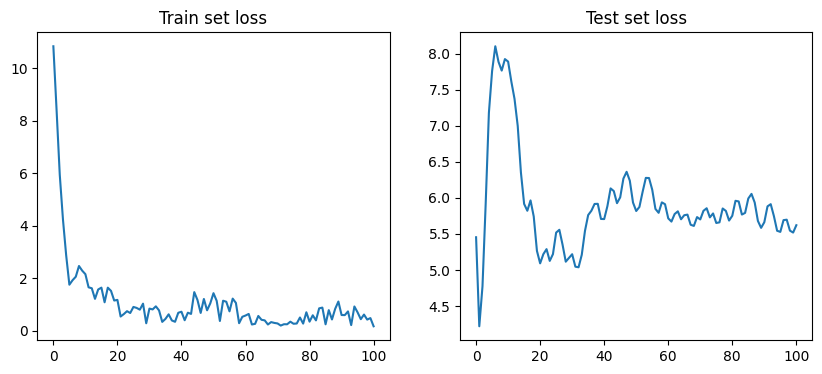

In [14]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(train_losses)
plt.title("Train set loss")
plt.subplot(122)
plt.plot(test_losses)
plt.title("Test set loss")

We can also compute a measure of accuracy for the train and test sets, where a prediction is considered accurate if it deviates at most 10% from the target.

Unfortunately the results are not comparable to those in the original paper. When looking at the implementation for the original paper (https://github.com/stefaniaebli/simplicial_neural_networks) a potential problem with the masking was found which could explain the difference (it seems that two masks are used, one for the imputation of the feature and one for the computation of the loss, where we use the same mask).

In [15]:
ground_truth = y_nodes[masks_train[rank]]
preds = y_hat[masks_train[rank]]

print("Train accuracy: ", (torch.abs((preds-ground_truth)/ground_truth)<0.1).sum()/preds.shape[0]*100)

Train accuracy:  tensor(100.)


In [16]:
ground_truth = y_nodes[masks_test[rank]]
preds = y_hat[masks_test[rank]]

print("Test accuracy: ", (torch.abs((preds-ground_truth)/ground_truth)<0.1).sum()/preds.shape[0]*100)

Test accuracy:  tensor(5.7692)
